Date: 2016-08-26

The purpose of this notebook is to develop code for exploratory analysis of the LFPs. The goals are to:

+  Plot LFP vs. time
+  Plot the periodograms of the LFPs
+  Plot the spectrograms (power vs. frequency in time) using multitaper spectral analysis
+  Plot the power at a frequency of interest vs. time
+  Plot the standardized power at a frequency of interest vs. time
+  Develop code that detects sharp wave ripples as in Jadhav et al. 2016

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
import os
import sys
import collections
import scipy.io
import scipy.fftpack
import scipy.signal
import scipy.ndimage
import numpy as np
import nitime.algorithms as tsa
import nitime.utils as utils
import nitime.viz
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import seaborn as sns
import pandas as pd
import tqdm

sys.path.append('../src/')
import data_filter as df

## Accessing the tetrode data

The following is some code to allow for accessing the needed tetrode data. For this exploratory analysis, I want to focus on the last day for animal *HPa* when the animal is running on the w-track. First check if we can get the correct epoch info.

In [2]:
Animal = collections.namedtuple('Animal', {'directory', 'short_name'})
num_days = 8
days = range(1, num_days + 1)
animals = {'HPa': Animal(directory='HPa_direct', short_name='HPa')}

epoch_info = df.make_epochs_dataframe(animals, days)
epoch_info.head()

environment   type
animal day epoch_ind                   
HPa    1   1            presleep  sleep
           2                 lin    run
           3                 NaN   rest
           4                wtr1    run
           5                 NaN   rest

Get the epoch dataframe corresponding to day 8, w-track

In [3]:
(epoch_info
    .loc[(['HPa'], [8]), :]
    .loc[epoch_info.environment == 'wtr1'])

,,,environment,type
animal,day,epoch_ind,,
HPa,8,2,wtr1,run


Next check if we can export the row index information as a tuple so we can use it as a dictionary key to access the tetrode information.

In [4]:
df.get_dataframe_index(epoch_info
    .loc[(['HPa'], [8]), :]
    .loc[epoch_info.environment == 'wtr1'])

[('HPa', 8, 2)]

Now get the information about the tetrodes. Notice that this structure is a dictionary with keys corresponding to (animal, day, epoch_index) tuples. These keys can access the corresponding dataframes with the tetrode information.

In [5]:
tetrode_info = df.make_tetrode_dataframe(animals)
tetrode_info.keys()

dict_keys([('HPa', 8, 4), ('HPa', 7, 5), ('HPa', 1, 2), ('HPa', 5, 3), ('HPa', 2, 3), ('HPa', 7, 4), ('HPa', 1, 3), ('HPa', 1, 1), ('HPa', 4, 3), ('HPa', 2, 2), ('HPa', 8, 5), ('HPa', 3, 2), ('HPa', 7, 1), ('HPa', 6, 2), ('HPa', 4, 2), ('HPa', 2, 1), ('HPa', 3, 3), ('HPa', 8, 1), ('HPa', 6, 4), ('HPa', 3, 4), ('HPa', 3, 5), ('HPa', 5, 4), ('HPa', 4, 5), ('HPa', 1, 7), ('HPa', 6, 3), ('HPa', 6, 5), ('HPa', 4, 4), ('HPa', 5, 2), ('HPa', 1, 4), ('HPa', 7, 2), ('HPa', 8, 2), ('HPa', 6, 1), ('HPa', 8, 3), ('HPa', 1, 5), ('HPa', 1, 6), ('HPa', 5, 5), ('HPa', 3, 1), ('HPa', 2, 5), ('HPa', 5, 1), ('HPa', 7, 3), ('HPa', 4, 1), ('HPa', 2, 4)])

Get the tetrode dataframes corresponding to the epoch we want and concatenate them to make a dataframe. In this case, there's only one key so the concatenation step doesn't do anything.

In [6]:
epoch_keys = df.get_dataframe_index(epoch_info
    .loc[(['HPa'], [8]), :]
    .loc[epoch_info.environment == 'wtr1'])

cur_tetrode_info = pd.concat([tetrode_info[key] for key in epoch_keys])
cur_tetrode_info

area  depth descrip  numcells
animal day epoch_ind tetrode_number                               
HPa    8   2         1                CA1    113  riptet        12
                     2                CA1    121     NaN         0
                     3                CA1     90  CA1Ref         0
                     4                CA1    116  riptet        15
                     5                CA1    116  riptet         0
                     6                CA1    110  riptet         0
                     7                CA1    114  riptet         0
                     8               iCA1    114  riptet         0
                     9               iCA1    100  riptet         0
                     10              iCA1     96     NaN         0
                     11              iCA1    106  riptet         0
                     12              iCA1    114  riptet         3
                     13              iCA1    120     NaN         0
                     14              iCA1    105  riptet         6
                     15               PFC     93     NaN         0
                     16               PFC     90     NaN         0
                     17               PFC     90     NaN         6
                     18               PFC     90     NaN         0
                     19               PFC    130     NaN         0
                     20               PFC    109     NaN         0

Now we have the tetrode information, we can extract keys that correspond to each tetrode. These can be used to access the tetrode LFP data.

In [7]:
tetrode_index = df.get_dataframe_index(cur_tetrode_info)
tetrode_index

[('HPa', 8, 2, 1),
 ('HPa', 8, 2, 2),
 ('HPa', 8, 2, 3),
 ('HPa', 8, 2, 4),
 ('HPa', 8, 2, 5),
 ('HPa', 8, 2, 6),
 ('HPa', 8, 2, 7),
 ('HPa', 8, 2, 8),
 ('HPa', 8, 2, 9),
 ('HPa', 8, 2, 10),
 ('HPa', 8, 2, 11),
 ('HPa', 8, 2, 12),
 ('HPa', 8, 2, 13),
 ('HPa', 8, 2, 14),
 ('HPa', 8, 2, 15),
 ('HPa', 8, 2, 16),
 ('HPa', 8, 2, 17),
 ('HPa', 8, 2, 18),
 ('HPa', 8, 2, 19),
 ('HPa', 8, 2, 20)]

## LFP - time domain

Now retrieve the tetrode data and plot the first tetrode to make sure we have the right data.

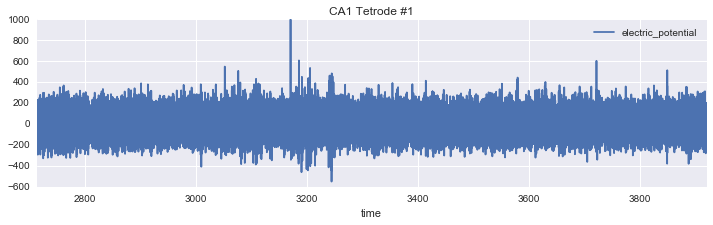

In [8]:
def tetrode_title(tetrode_index_tuple, cur_tetrode_info):
    return '{brain_area} Tetrode #{tetrode_number}'.format(tetrode_number=tetrode_index_tuple[-1],
                     brain_area=cur_tetrode_info.loc[tetrode_index_tuple]['area'])

lfp_data = df.get_LFP_data(tetrode_index, animals)
lfp_data[0].plot(title=tetrode_title(tetrode_index[0], cur_tetrode_info), figsize=(12,3))

Now plot all the tetrodes

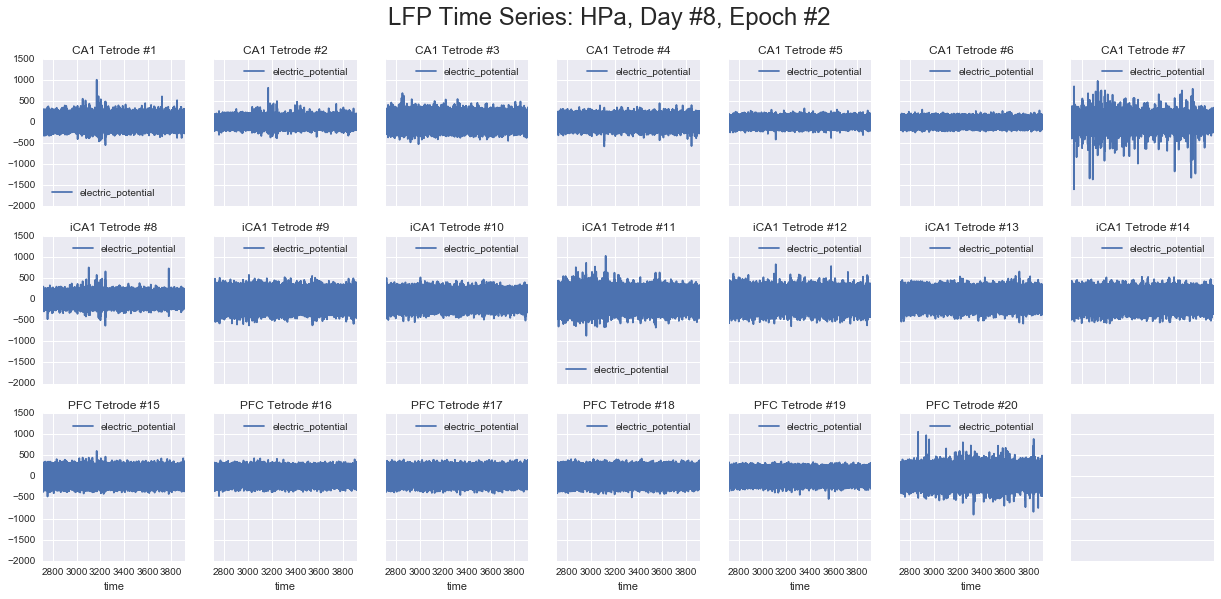

In [9]:
num_rows = int(np.ceil(len(tetrode_index) / 7))
fig, axis_handles = plt.subplots(num_rows, 7, figsize=(21, 9), sharex=True, sharey=True)
for tetrode_ind, axis_handle in enumerate(axis_handles.flatten()):
    try:
        lfp_data[tetrode_ind].plot(ax=axis_handle,
                                   title=tetrode_title(tetrode_index[tetrode_ind], cur_tetrode_info),
                                  )
    except IndexError:
        axis_handle.xaxis.set_visible(False)
        
plt.suptitle('LFP Time Series: HPa, Day #8, Epoch #2', fontsize=24)

## Periodograms

The following is hand coded to make sure I understand the calculation for the periodogram.

/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


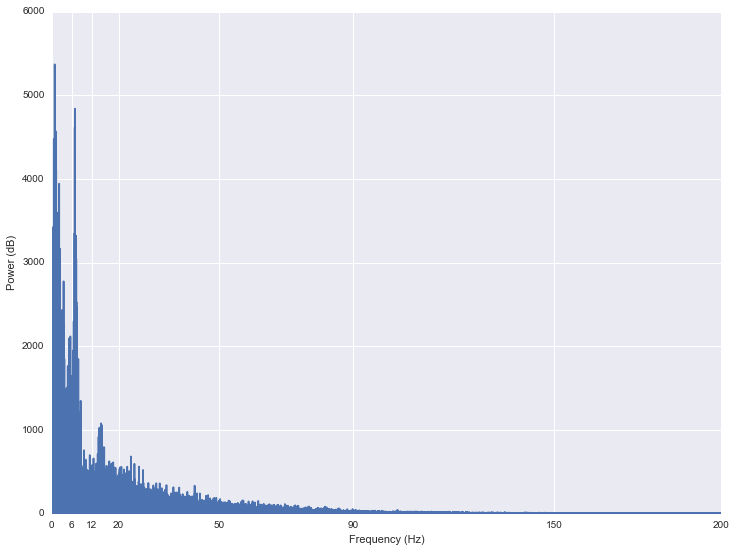

In [10]:
def plot_spectrum_by_hand(data_frame, sampling_frequency, axis_handle):
    
    data = data_frame['electric_potential'] - data_frame['electric_potential'].mean()
    number_samples = data.size
    number_fft_bins = np.floor(number_samples / 2) + 1
    nyquist = 0.5 * sampling_frequency

    dft = scipy.fftpack.fft(data)
    frequencies = np.linspace(0.0, nyquist, number_fft_bins)
    power = np.abs(dft[0:number_fft_bins])**2 / (number_fft_bins * sampling_frequency)
    axis_handle.plot(frequencies, power)
    plt.xlim((0, 200))
    plt.xticks([0, 6, 12, 20, 50, 90, 150, 200])

fig, axis_handle = plt.subplots(1, 1, figsize=(12, 9))
sampling_frequency = 1500
plot_spectrum_by_hand(lfp_data[0], sampling_frequency, axis_handle)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB)')

Compare to *scipy.signal* package periodogram

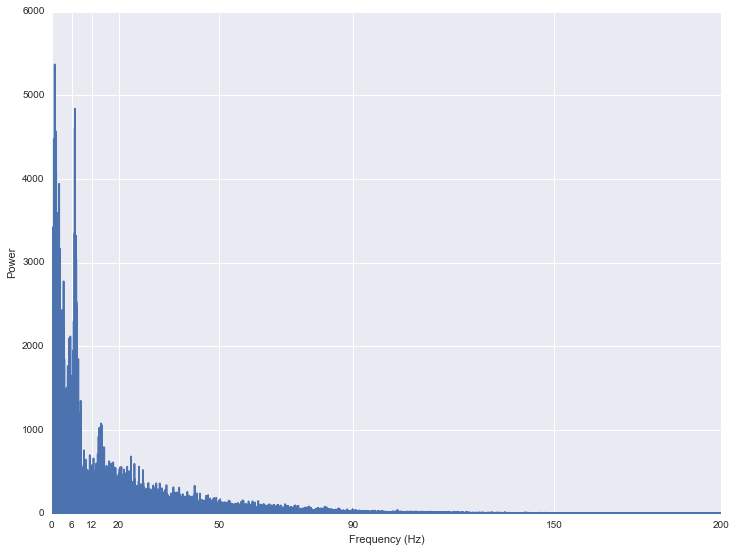

In [11]:
def plot_spectrum_scipy(data_frame, sampling_frequency, axis_handle):
    frequencies, power_spectral_density = scipy.signal.periodogram(data_frame['electric_potential'], 
                                                                   fs=sampling_frequency,
                                                                   nfft=data_frame['electric_potential'].size,
                                                                   detrend='constant')
    axis_handle.plot(frequencies, power_spectral_density)
    plt.xlim([0, 200])
    plt.xticks([0, 6, 12, 20, 50, 90, 150, 200])
    
fig, axis_handle = plt.subplots(1, 1, figsize=(12, 9))
sampling_frequency = 1500
plot_spectrum_scipy(lfp_data[0], sampling_frequency, axis_handle)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')

Compare to the *nitime* package periodogram

([<matplotlib.axis.XTick at 0x15c7c52b0>,
 <a list of 8 Text xticklabel objects>)

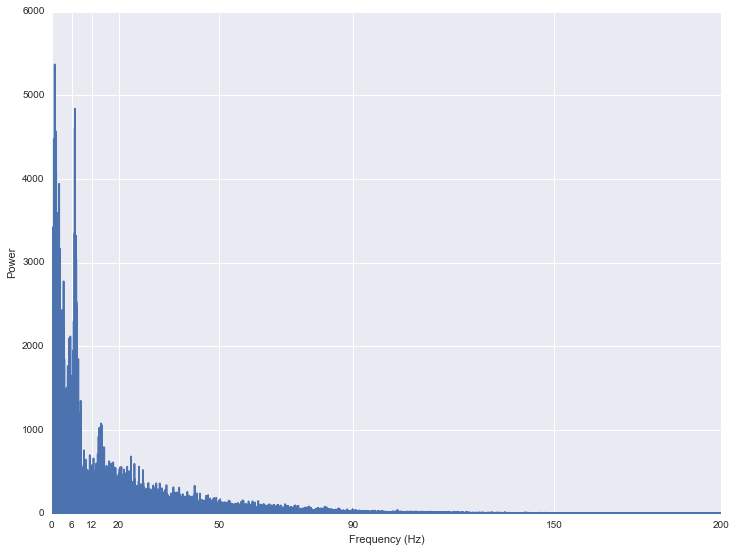

In [12]:
def plot_spectrum_nitime(data_frame, sampling_frequency, axis_handle):
    frequencies, power_spectral_density = tsa.periodogram(data_frame['electric_potential'] - data_frame['electric_potential'].mean(),
                                                          Fs=sampling_frequency,
                                                          normalize=True)
    axis_handle.plot(frequencies, power_spectral_density)
    
fig, axis_handle = plt.subplots(1, 1, figsize=(12, 9))
sampling_frequency = 1500
plot_spectrum_nitime(lfp_data[0], sampling_frequency, axis_handle)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.xlim([0, 200])
plt.xticks([0, 6, 12, 20, 50, 90, 150, 200])

Now plot all the periodgrams.

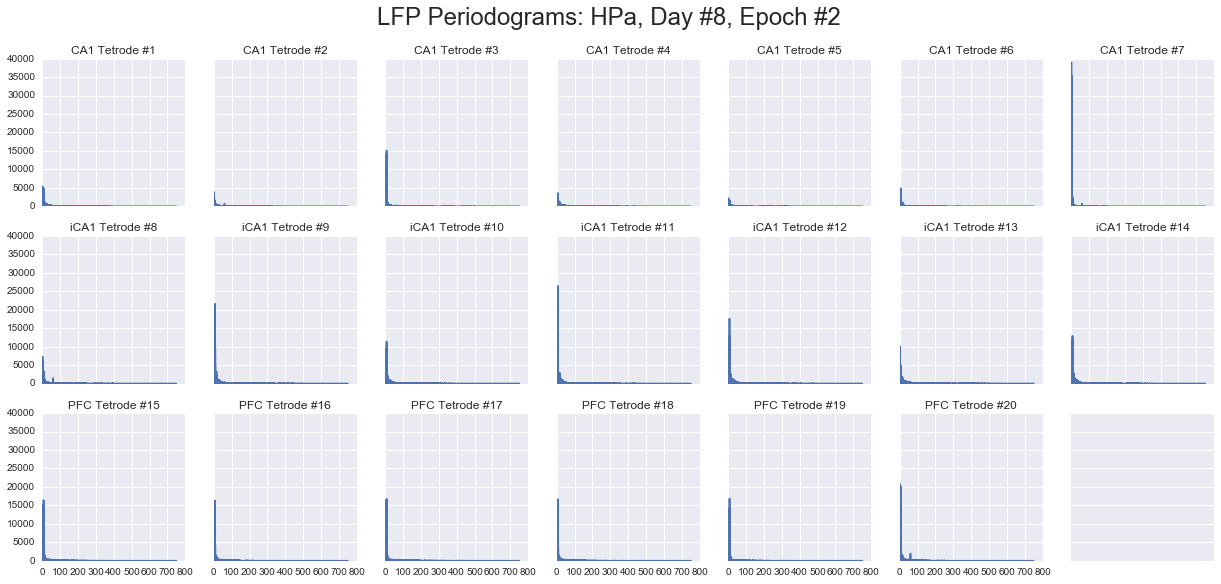

In [13]:
num_rows = int(np.ceil(len(tetrode_index) / 7))
fig, axis_handles = plt.subplots(num_rows, 7, figsize=(21, 9), sharex=True, sharey=True)
for tetrode_ind, axis_handle in enumerate(axis_handles.flatten()):
    try:
        plot_spectrum_nitime(lfp_data[tetrode_ind], sampling_frequency, axis_handle)
        axis_handle.set_title(tetrode_title(tetrode_index[tetrode_ind], cur_tetrode_info))
    except IndexError:
        axis_handle.xaxis.set_visible(False)
        
plt.suptitle('LFP Periodograms: HPa, Day #8, Epoch #2', fontsize=24)

## Multitaper Spectral Analysis

Let's try to get a better estimate with the multitaper spectrum. Using tapers gives better control over the amount of smoothing in the frequency domain, reducing the bias of the estimate of the signal. The tapers can be designed to tradeoff between the narrow-band bias (the frequency resolution) and the broad-band bias (the spectral leakage from the sidelobes of the smoothing kernel). Using multiple orthogonal tapers that overlap in time-frequency subdomains and averaging over the tapers reduces the variance.

Multitaper spectrum analysis requires three parameters to be set (the frequency resolution, the time window, and the number of tapers). Smaller frequency resolutions are needed to resolve lower frequency rhythms. Smaller time windows are needed for quickly changing non-stationary processes. More tapers are needed to give better control over frequency domain smoothing and reduce the variance of the estimate.

For hippocampal data, the important rhythms are the theta (6-12 Hz), the low gamma (20-50 Hz), the high gamma (50-90 Hz), and the sharp wave ripple band (150-250 Hz).

For prefrontal cortex, the important rhythms are alpha (8-12 Hz), beta (15-30 Hz), and gamma (30-60 Hz).

For the alpha/theta bands we need a good frequency resolution like 2 Hz. This implies a half-bandwidth ($W$) of 1 Hz. The time-half-bandwidth product ($T * W$) has to be greater than 1 ($T*W \ge 1$) where $T$ is the length of time of the signal, so $T = 1$ second. The optimal number of tapers is $2 * T * W - 1$, so we need one taper.

For the beta/gamma bands, we can reduce the frequency resolution to 5 or 10 Hz. For the sharp wave ripple band, we could decrease this to 25 or 50 Hz.

The following table lists the different tradeoffs for frequency resolution, window time length and number of tapers:

| Frequency Resolution (Hz)  | Window Time Length (sec) | Number of Tapers  |
| --- | ---    |:-:|
| 2   | 1.000  | 1  |
| 5   | 0.500  | 1  |
| 10  | 0.200  | 1  |
| 25  | 0.080  | 1  |
| 50  | 0.040  | 1  |
| 2   | 3.000  | 5  |
| 5   | 1.200  | 5  |
| 10  | 0.600  | 5  |
| 25  | 0.240  | 5  |
| 50  | 0.120  | 5  |


It would probably be best to run the multitaper analysis with a couple of different sets of parameters in order to capture the different aspects of the signal. For the alpha/theta, use 2 Hz frequency resolution, 1.000 second window, 1 taper. For beta/gamma/sharp wave ripple, use 10 Hz frequency resolution, 0.600 second window, 5 tapers. For just the timing of the sharp wave ripple, 50 Hz frequency resolution, 0.040 second window, 1 taper.

### Prototyping code for the multitaper power spectral density

The following is just some prototype code for computing the multitaper power spectral density over successive windows. The plot corresponds to the power spectral density for each window.

Some notes on the code:

The time domain signal is centered at zero for each window.

The sliding windows share only the last time point (due to how the Pandas package dataframe selection includes both the start and end points given. This may have to change in the future. Alternatively, could put in a paramter that allows for more sliding window overlap.

Lastly, the last time window is excluded because there aren't enough data points. If more window overlap was allowed, this would increase use of the data. Not sure if there's a better solution.

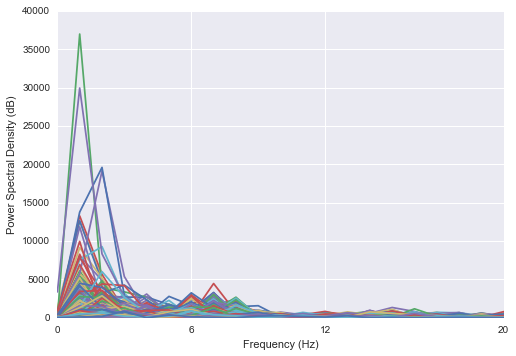

In [14]:
time_window_start = lfp_data[0].index[0]
time_window_duration = 1.00

while time_window_start + time_window_duration < lfp_data[0].index[-1]:
    try:
        windowed_data_frame = lfp_data[0].loc[time_window_start:(time_window_start + time_window_duration), :]
        frequencies, power_spectral_density, _ = tsa.multi_taper_psd(windowed_data_frame['electric_potential'] - windowed_data_frame['electric_potential'].mean(),
                                                                      BW=2,
                                                                      Fs=sampling_frequency,
                                                                      adaptive=False,
                                                                      jackknife=False
                                                                      )
        plt.plot(frequencies, power_spectral_density)
        plt.xlim([0, 20])
        plt.xticks([0, 6, 12, 20])
        plt.ylabel('Power Spectral Density (dB)')
        plt.xlabel('Frequency (Hz)')
        time_window_start += time_window_duration
    except ValueError:
        pass

Now take the prototype code, turn it into a generator function that returns a power spectral density dataframe for each time window. The dataframe consists of the index (time, frequency), where time corresponds to the mid-point time of the window. The frequencies are the frequencies returned from the *nitime* multi-taper psd function. The dataframe has one column corresponding to power, which is the power spectral density calculated the *nitime* package.

The dataframe generator can be looped through and concatenated to get the spectrogram dataframe.

In [15]:
def make_timefrequency_dataframe(lfp_data_frame, time_window_duration, time_window_step, frequency_resolution, sampling_frequency):
    ''' Generator function that returns a power spectral density data frame for each time window
    '''
    time_window_start = 0
    number_points_time_window = int(np.fix(time_window_duration * sampling_frequency))
    number_points_time_step = int(np.fix(time_window_step * sampling_frequency))

    while time_window_start + number_points_time_window < len(lfp_data_frame):
        try:
            time_window_end = time_window_start + number_points_time_window
            windowed_data_frame = lfp_data_frame.iloc[time_window_start:time_window_end, :]
            frequencies, power_spectral_density, _ = tsa.multi_taper_psd(windowed_data_frame['electric_potential'] - windowed_data_frame['electric_potential'].mean(),
                                                                          BW=frequency_resolution,
                                                                          Fs=sampling_frequency,
                                                                          adaptive=False,
                                                                          jackknife=False
                                                                          )
            yield (pd.DataFrame({
                                'power': power_spectral_density,
                                'frequency': np.round(frequencies, decimals=3)
                                })
                                .assign(time=lambda x: np.round(lfp_data_frame.index.values[time_window_start] + (time_window_duration / 2), decimals=4))
                                )
            time_window_start += number_points_time_step
        except ValueError:
            # Not enough data points
            pass

def get_spectrogram_dataframe(lfp_data_frame, sampling_frequency=1000, frequency_resolution=2, time_window_duration=1, time_window_step=0):
    ''' Returns a pandas dataframe with the information for a spectrogram. Sampling frequency and frequency
    resolution inputs are given in Hertz. Time window duration and steps are given in seconds.
    '''
    if time_window_step == 0:
        time_window_step = time_window_duration
    return pd.concat((time_window
                      for time_window in make_timefrequency_dataframe(lfp_data_frame,
                                                                      time_window_duration,
                                                                      time_window_step,
                                                                      frequency_resolution,
                                                                      sampling_frequency)))

In [16]:
frequency_resolution = 2
time_window_duration = 1
sampling_frequency = 1500
time_window_step = time_window_duration / 2
spectrogram = get_spectrogram_dataframe(lfp_data[0],
                                        frequency_resolution=frequency_resolution,
                                        time_window_duration=time_window_duration,
                                        sampling_frequency=sampling_frequency,
                                        time_window_step=time_window_step)

spectrogram.head()

,frequency,power,time
0,0.0,9.745951,2713.4948
1,1.0,111.634740,2713.4948
2,2.0,346.019641,2713.4948
3,3.0,562.672609,2713.4948
4,4.0,19.718734,2713.4948


If we pivot the spectrogram dataframe, we get a two-dimensional array with frequency on the y-axis and time on the x-axis

In [17]:
spectrogram.pivot('frequency', 'time', 'power')

time,2713.4948,2713.9948,2714.4948,2714.9948,2715.4948,2715.9948,2716.4948,2716.9948,2717.4948,2717.9948,...,3914.9949,3915.4949,3915.9949,3916.4949,3916.9949,3917.4949,3917.9949,3918.4949,3918.9949,3919.4949
frequency,,,,,,,,,,,,,,,,,,,,,
0.0,9.745951,6.362539,27.732212,5.917123,3.650063,6.940113,2.061648e+00,120.440799,0.075193,112.697688,...,64.974900,69.496085,13.202142,59.322530,3.377219,1.688537,1.329371,71.483425,97.821297,16.453320
1.0,111.634740,33.151833,108.732378,46.514179,284.128803,391.463048,5.565351e+02,1358.339987,479.811706,1377.505036,...,948.693800,925.922444,503.737218,438.462336,20.390079,118.975513,86.669778,503.010180,666.548472,106.570633
2.0,346.019641,848.785288,12.738344,9.481091,688.665054,851.619984,2.959881e+02,350.492282,1304.749580,330.814450,...,988.348157,508.349305,836.706119,134.971445,268.301811,538.099463,295.807257,614.028046,365.651909,186.510312
3.0,562.672609,314.992579,466.181980,254.743371,619.143095,102.239638,3.094345e+02,228.302585,29.906341,630.482113,...,495.039078,128.772579,3.674497,89.051187,260.434143,391.007002,174.420333,197.420525,392.761581,846.537442
4.0,19.718734,86.598309,543.763036,98.040628,6.103205,46.264467,1.203846e+02,276.879102,77.677463,141.674710,...,77.402016,22.178221,76.176241,146.492076,89.846631,41.833086,150.700662,110.447949,423.168836,0.011780
5.0,397.216604,102.756020,1400.722811,1152.485271,462.074643,199.609446,1.081479e+02,48.597044,61.567197,299.046498,...,41.471532,66.848224,189.433861,380.967584,2.913539,128.175006,73.985897,220.872535,345.723742,352.477938
6.0,1329.227906,652.838610,1676.203324,1056.922428,710.445028,94.315713,1.674088e+02,249.884752,53.954529,150.905760,...,572.144177,113.987375,45.547592,19.840563,46.080856,246.160359,153.077768,862.139330,1213.893361,155.526944
7.0,149.775340,324.089474,259.459660,50.964451,1.960415,107.644031,1.298348e+01,129.358399,241.066790,649.347790,...,477.155587,188.004681,86.889048,310.949836,46.986761,40.496541,216.995712,393.011196,79.580547,56.665575
8.0,180.283287,676.374234,62.182004,74.560905,64.306257,2.283609,1.803855e+01,37.733601,18.776231,401.706054,...,193.482565,527.984673,1366.115527,290.571764,204.744926,104.401611,90.685429,268.352777,11.407603,18.282818


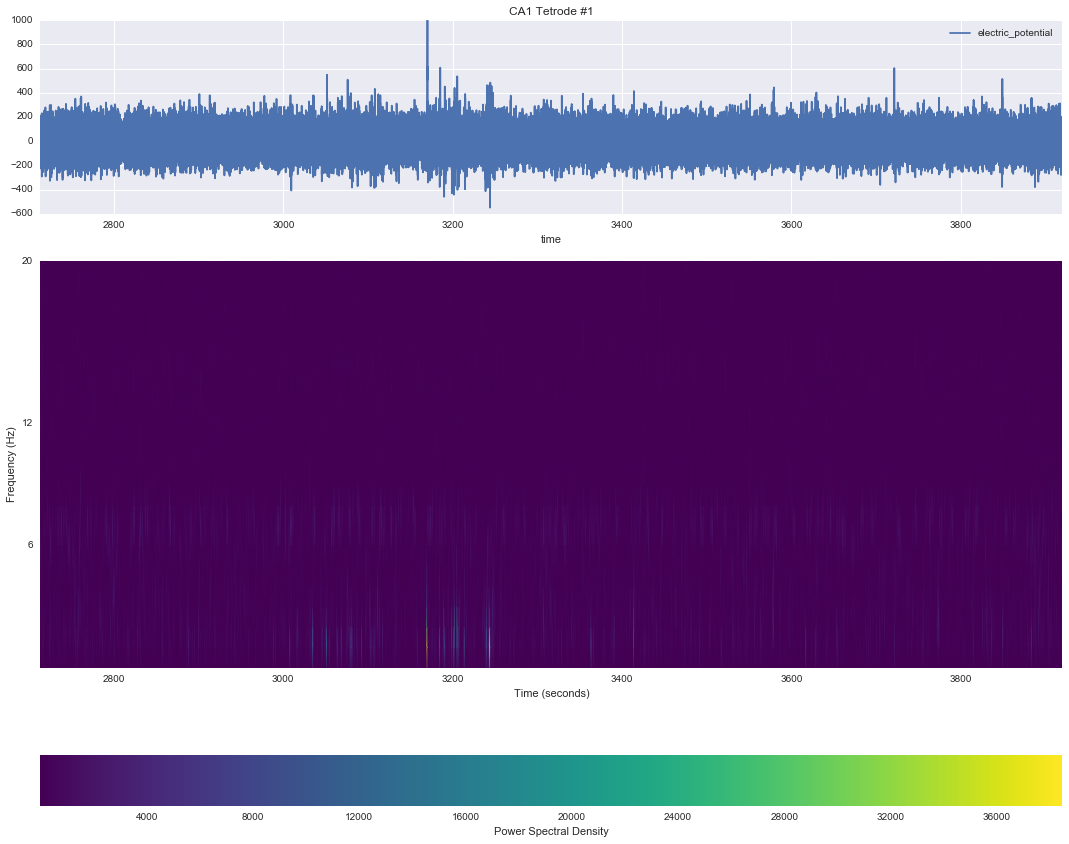

In [18]:
def _get_time_freq_from_spectrogram(spectrogram_dataframe):
    return (np.unique(spectrogram_dataframe['time']), np.unique(spectrogram_dataframe['frequency']))

def plot_spectrogram(spectrogram_dataframe, axis_handle):
    time, freq = _get_time_freq_from_spectrogram(spectrogram_dataframe)
    mesh = axis_handle.pcolormesh(time, freq, spectrogram_dataframe.pivot('frequency', 'time', 'power'),
                                  cmap='viridis',
                                  shading='gouraud')
    axis_handle.set_ylabel('Frequency (Hz)')
    axis_handle.set_xlabel('Time (seconds)')
    axis_handle.set_xlim([time.min(), time.max()])
    axis_handle.set_ylim([freq.min(), freq.max()])
    return mesh
    
    
fig, axis_handles = plt.subplots(2, 1, figsize=(15, 12), gridspec_kw={'height_ratios':[1, 3]})

lfp_data[0].plot(title=tetrode_title(tetrode_index[0], cur_tetrode_info), ax=axis_handles[0])

mesh = plot_spectrogram(spectrogram.loc[(spectrogram.frequency <= 20)], axis_handles[1])
yticks = [6, 12, 20]
axis_handles[1].set_yticks(yticks)
fig.colorbar(mesh, label='Power Spectral Density', orientation='horizontal')
plt.tight_layout()

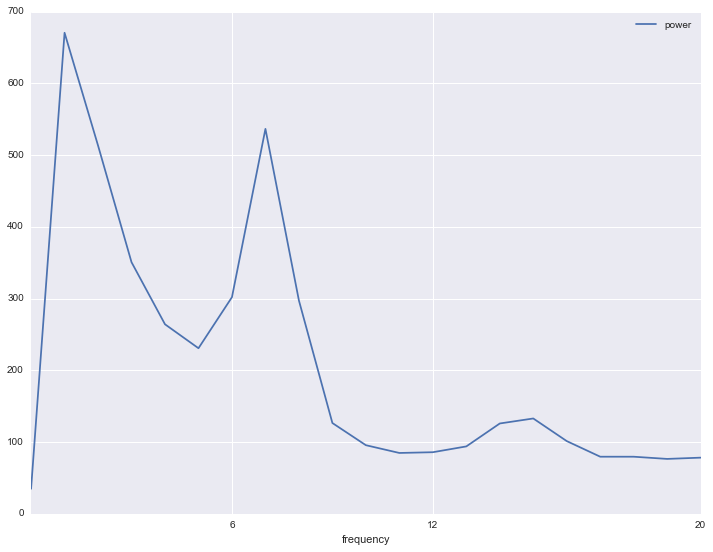

In [19]:
def plot_spectrum(spectrogram_dataframe, axis_handle):
    (spectrogram_dataframe.groupby('frequency')
                         .agg(np.mean)
                         .drop('time', 1)
                         .plot(ax=axis_handle))   

fig, axis_handle = plt.subplots(1, 1, figsize=(12, 9))
plot_spectrum(spectrogram.loc[spectrogram.frequency <= 20], axis_handle)
xticks = [6, 12, 20]
axis_handle.set_xticks(xticks) 

Now compute for all tetrodes

In [20]:
frequency_resolution = 2
time_window_duration = 1
sampling_frequency = 1500
time_window_step = time_window_duration / 2

spectrograms_1 = [get_spectrogram_dataframe(tetrode,
                           frequency_resolution=frequency_resolution,
                           time_window_duration=time_window_duration,
                           sampling_frequency=sampling_frequency,
                           time_window_step=time_window_step) for tetrode in tqdm.tqdm_notebook(lfp_data)]


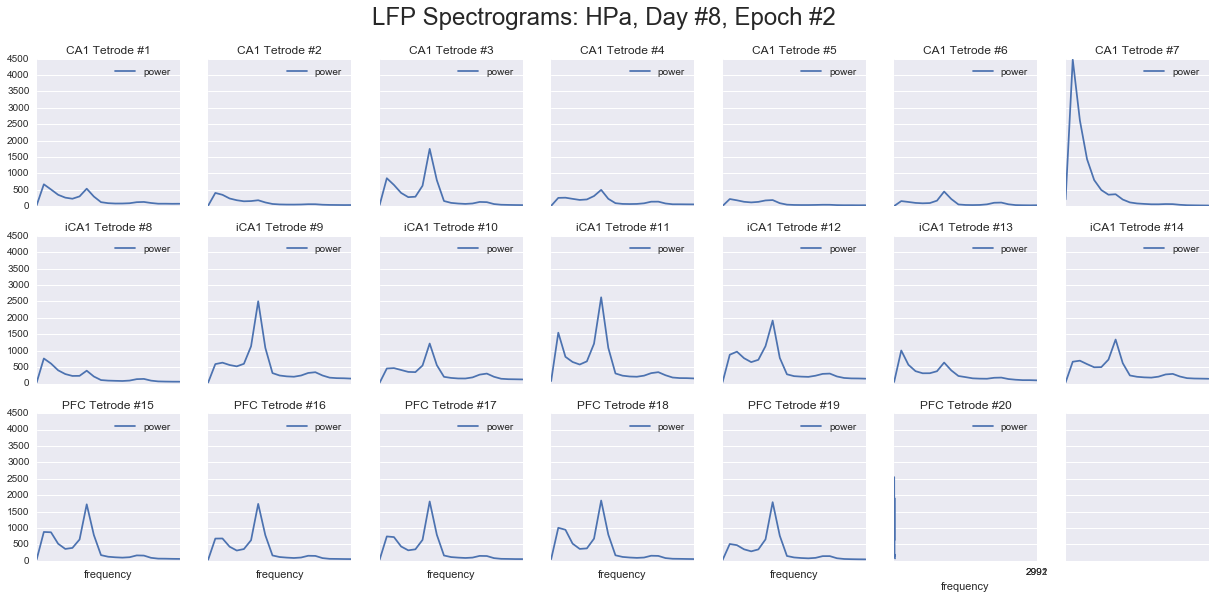

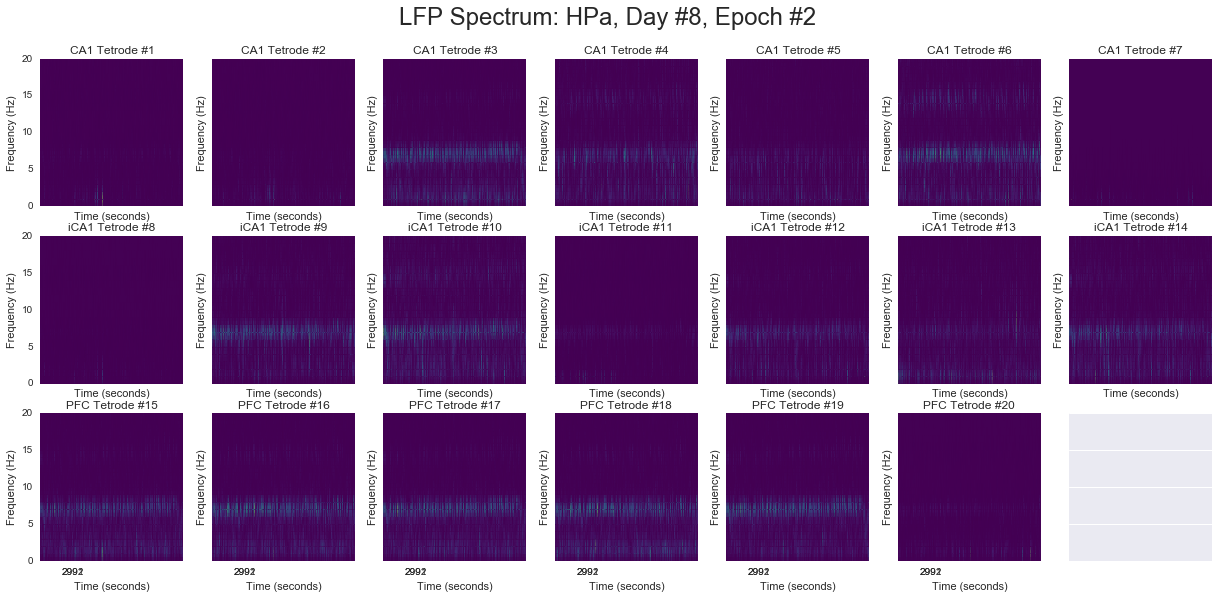

In [21]:
# Spectrum
num_rows = int(np.ceil(len(tetrode_index) / 7))
fig, axis_handles = plt.subplots(num_rows, 7, figsize=(21, 9), sharex=True, sharey=True)
for tetrode_ind, axis_handle in enumerate(tqdm.tqdm_notebook(axis_handles.flatten())):
    try:
        selection = spectrograms_1[tetrode_ind].frequency <= 20
        mesh = plot_spectrum(spectrograms_1[tetrode_ind].loc[selection], axis_handle)
        xticks = [6, 12, 20]
        axis_handle.set_xticks((2991, 2992))
        axis_handle.set_title(tetrode_title(tetrode_index[tetrode_ind], cur_tetrode_info))
    except IndexError:
        axis_handle.xaxis.set_visible(False)
        
plt.suptitle('LFP Spectrograms: HPa, Day #8, Epoch #2', fontsize=24)


# Spectrograms
num_rows = int(np.ceil(len(tetrode_index) / 7))
fig, axis_handles = plt.subplots(num_rows, 7, figsize=(21, 9), sharex=True, sharey=True)
for tetrode_ind, axis_handle in enumerate(tqdm.tqdm_notebook(axis_handles.flatten())):
    try:
        selection = spectrograms_1[tetrode_ind].frequency <= 20
        mesh = plot_spectrogram(spectrograms_1[tetrode_ind].loc[selection], axis_handle)
        axis_handle.set_title(tetrode_title(tetrode_index[tetrode_ind], cur_tetrode_info))
        axis_handle.set_xticks((2991, 2992))
    except IndexError:
        axis_handle.xaxis.set_visible(False)
        
plt.suptitle('LFP Spectrum: HPa, Day #8, Epoch #2', fontsize=24)

It's hard to tell if the colorscale is wonky on the above plots. Let's try something with a lower frequency resolution to compare.

In [22]:
frequency_resolution = 10
time_window_duration = 0.600
sampling_frequency = 1500
time_window_step = time_window_duration / 2

spectrograms_2 = [get_spectrogram_dataframe(tetrode,
                           frequency_resolution=frequency_resolution,
                           time_window_duration=time_window_duration,
                           sampling_frequency=sampling_frequency,
                           time_window_step=time_window_step) for tetrode in tqdm.tqdm_notebook(lfp_data)]


Comparing the spectra of the different multi-tapers. Blue is lower frequency resolution but more tapers (10 Hz, 5 tapers). Green is higher frequency resolution, but less tapers (2 Hz, 1 taper).

In [23]:
(spectrograms_2[0].groupby('frequency')
                     .agg(np.mean)
                     .drop('time', 1))

,power
frequency,
0.000,176.189006
1.667,343.663910
3.333,332.272248
5.000,347.056242
6.667,267.966693
8.333,218.165062
10.000,191.973831
11.667,142.246020
13.333,101.140350


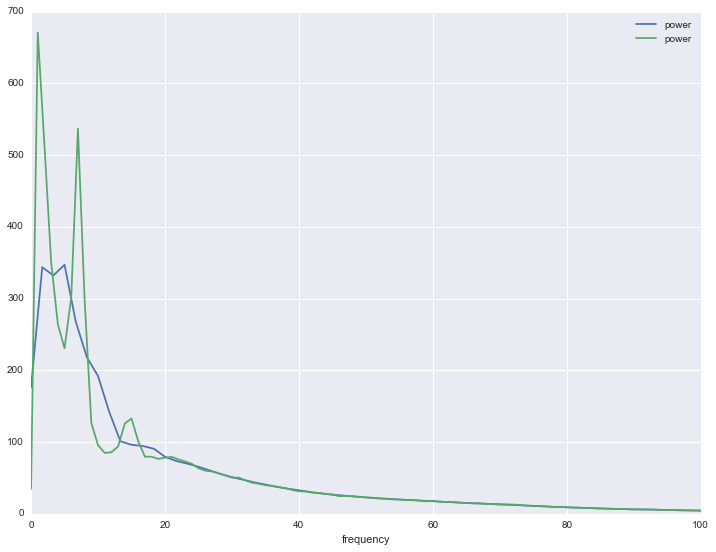

In [24]:
fig, axis_handle = plt.subplots(1, 1, figsize=(12, 9))
plot_spectrum(spectrograms_2[0].loc[spectrograms_2[0].frequency <= 100], axis_handle)
plot_spectrum(spectrograms_1[0].loc[spectrograms_1[0].frequency <= 100], axis_handle)

In [25]:
frequency_resolution = 10
time_window_duration = 0.600
sampling_frequency = 1500
time_window_step = time_window_duration / 2

spectrogram_2 = get_spectrogram_dataframe(lfp_data[0],
                           frequency_resolution=frequency_resolution,
                           time_window_duration=time_window_duration,
                           sampling_frequency=sampling_frequency,
                           time_window_step=time_window_step)



In [26]:
spectrogram_2.head()

,frequency,power,time
0,0.000,37.325004,2713.2948
1,1.667,161.332339,2713.2948
2,3.333,281.598864,2713.2948
3,5.000,293.425531,2713.2948
4,6.667,287.148589,2713.2948


Compute all of the spectra / spectrograms for the 10 Hz frequency resolution.

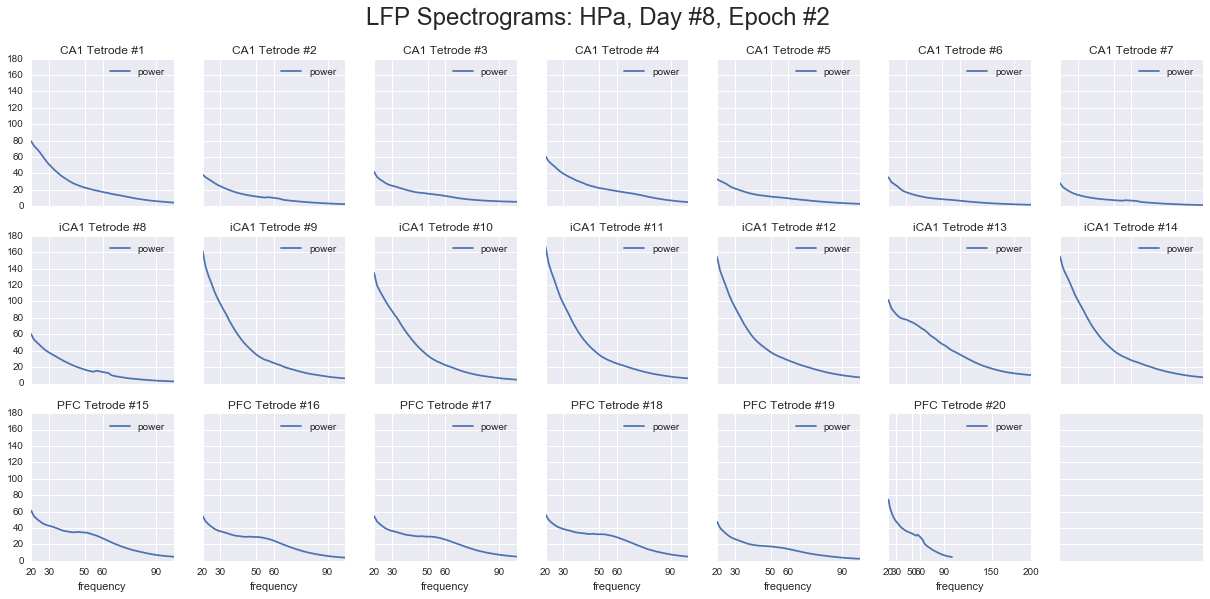

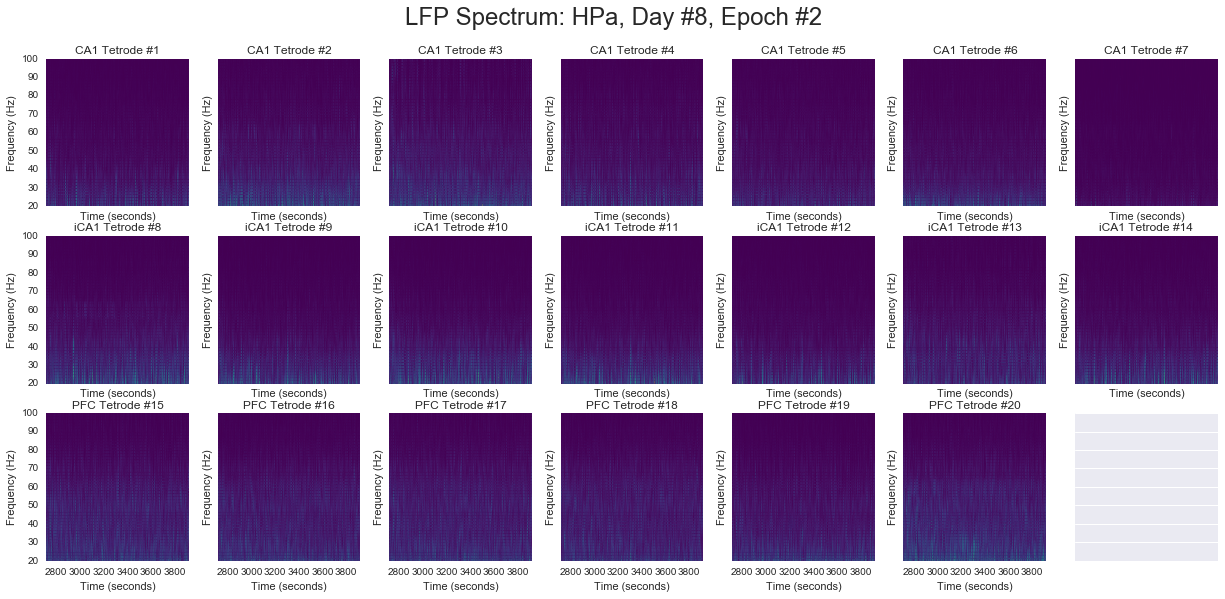

In [27]:
# Spectrum
num_rows = int(np.ceil(len(tetrode_index) / 7))
fig, axis_handles = plt.subplots(num_rows, 7, figsize=(21, 9), sharex=True, sharey=True)
for tetrode_ind, axis_handle in enumerate(tqdm.tqdm_notebook(axis_handles.flatten())):
    try:
        mesh = plot_spectrum(spectrograms_2[tetrode_ind].loc[(spectrograms_2[tetrode_ind].frequency >= 20) & (spectrograms_2[tetrode_ind].frequency <= 100)], axis_handle)
        xticks = [20, 30, 50, 60, 90, 150, 200]
        axis_handle.set_xticks(xticks)
        axis_handle.set_title(tetrode_title(tetrode_index[tetrode_ind], cur_tetrode_info))
    except IndexError:
        axis_handle.xaxis.set_visible(False)
        
plt.suptitle('LFP Spectrograms: HPa, Day #8, Epoch #2', fontsize=24)


# Spectrograms
num_rows = int(np.ceil(len(tetrode_index) / 7))
fig, axis_handles = plt.subplots(num_rows, 7, figsize=(21, 9), sharex=True, sharey=True)
for tetrode_ind, axis_handle in enumerate(tqdm.tqdm_notebook(axis_handles.flatten())):
    try:
        mesh = plot_spectrogram(spectrograms_2[tetrode_ind].loc[(spectrograms_2[tetrode_ind].frequency >= 20) & (spectrograms_2[tetrode_ind].frequency <= 100)], axis_handle)
        axis_handle.set_title(tetrode_title(tetrode_index[tetrode_ind], cur_tetrode_info))
    except IndexError:
        axis_handle.xaxis.set_visible(False)
        
plt.suptitle('LFP Spectrum: HPa, Day #8, Epoch #2', fontsize=24)

The spectra/spectrograms above don't quite look right. Maybe the number of tapers is throwing things off? The next cell compares two spectra with frequency resolution of 2 Hz, but different time window lengths of 1 second and 3 seconds (hence different numbers of tapers, 1 vs. 5 respectively). There should be more smoothing in the frequency domain with more tapers.

In [28]:
frequency_resolution = 2
time_window_duration = 3
sampling_frequency = 1500
time_window_step = time_window_duration / 2

spectrograms_3 = [get_spectrogram_dataframe(lfp_data[0],
                           frequency_resolution=frequency_resolution,
                           time_window_duration=time_window_duration,
                           sampling_frequency=sampling_frequency,
                           time_window_step=time_window_step)]


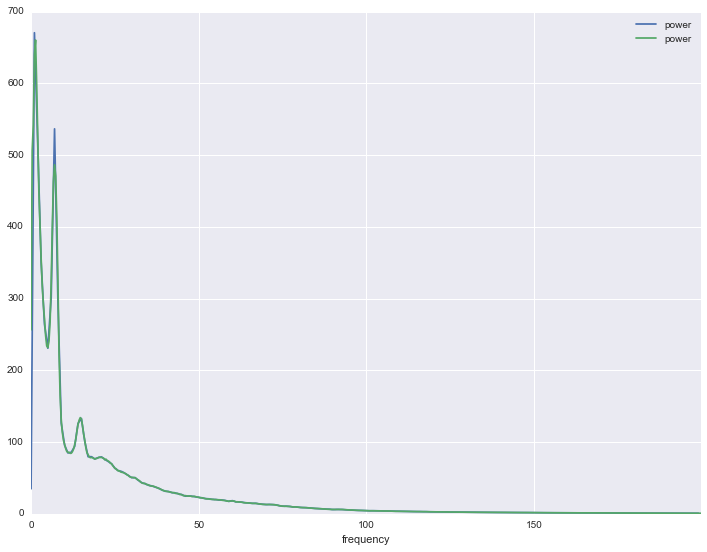

In [29]:
fig, axis_handle = plt.subplots(1, 1, figsize=(12, 9))
plot_spectrum(spectrograms_1[0].loc[spectrograms_1[0].frequency < 200], axis_handle)
plot_spectrum(spectrograms_3[0].loc[spectrograms_3[0].frequency < 200], axis_handle)

## Sharp Wave Ripples

For the sharp wave ripples, want low frequency resolution, good time resolution.

In [30]:
frequency_resolution = 100
time_window_duration = 0.020
sampling_frequency = 1500
time_window_step = time_window_duration / 2

spectrograms_swr = [get_spectrogram_dataframe(tetrode,
                           frequency_resolution=frequency_resolution,
                           time_window_duration=time_window_duration,
                           sampling_frequency=sampling_frequency,
                           time_window_step=time_window_step) for tetrode in tqdm.tqdm_notebook(lfp_data)]

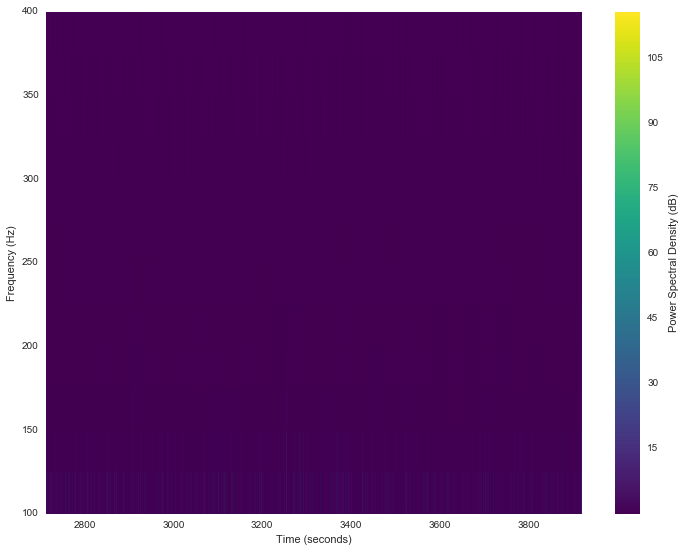

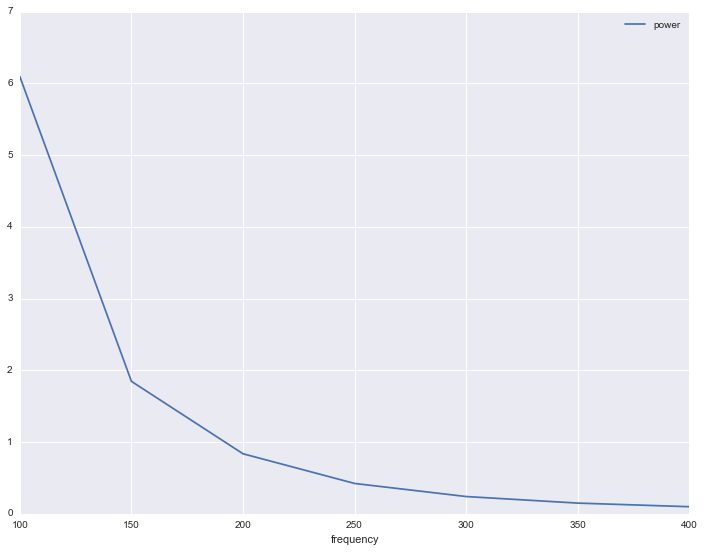

In [31]:
fig, axis_handle = plt.subplots(1, 1, figsize=(12, 9))
mesh = plot_spectrogram(spectrograms_swr[0].loc[(spectrograms_swr[0].frequency >= 100) & (spectrograms_swr[0].frequency <= 400)], axis_handle)
plt.colorbar(mesh, label='Power Spectral Density (dB)')

fig, axis_handle = plt.subplots(1, 1, figsize=(12, 9))
plot_spectrum(spectrograms_swr[0].loc[(spectrograms_swr[0].frequency >= 100) & (spectrograms_swr[0].frequency <= 400)], axis_handle)

,frequency,power,time
4,200.0,2.211998,2713.0048
4,200.0,0.599675,2713.0148
4,200.0,0.648345,2713.0248
4,200.0,0.084342,2713.0348
4,200.0,0.176088,2713.0448


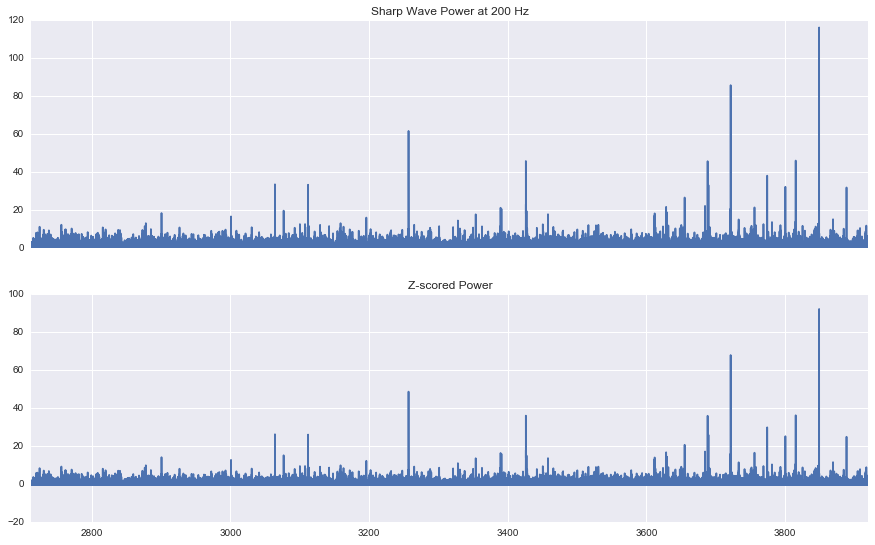

In [32]:
fig, axis_handles = plt.subplots(2, 1, figsize=(15, 9), sharex=True)

sharp_wave_power = spectrograms_swr[0].loc[(spectrograms_swr[0].frequency == 200)]
time = sharp_wave_power['time']
axis_handles[0].plot(time, sharp_wave_power['power'])
axis_handles[0].set_title('Sharp Wave Power at 200 Hz')

# zscore
def zscore(x):
    return (x - x.mean()) / x.std()

z_sharp_wave_power = zscore(sharp_wave_power['power'])

axis_handles[1].plot(time, z_sharp_wave_power, label='z-scored')
axis_handles[1].set_title('Z-scored Power')
axis_handles[1].set_xlim((time.min(), time.max()))

sharp_wave_power.head()

# Average across electrodes to get a consensus trace

# Threshold at zscore of 3

# Needs to stay above threshold for at least 15 ms on at least one tetrode

# Start and end of ripple are when the zscore exceeds the mean around the event

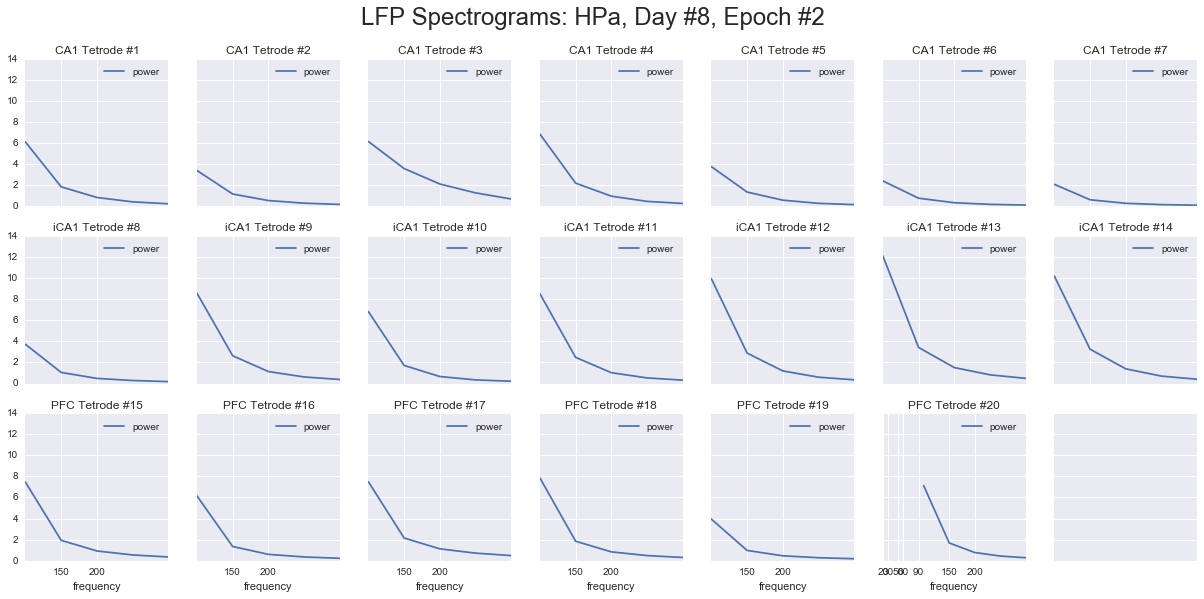

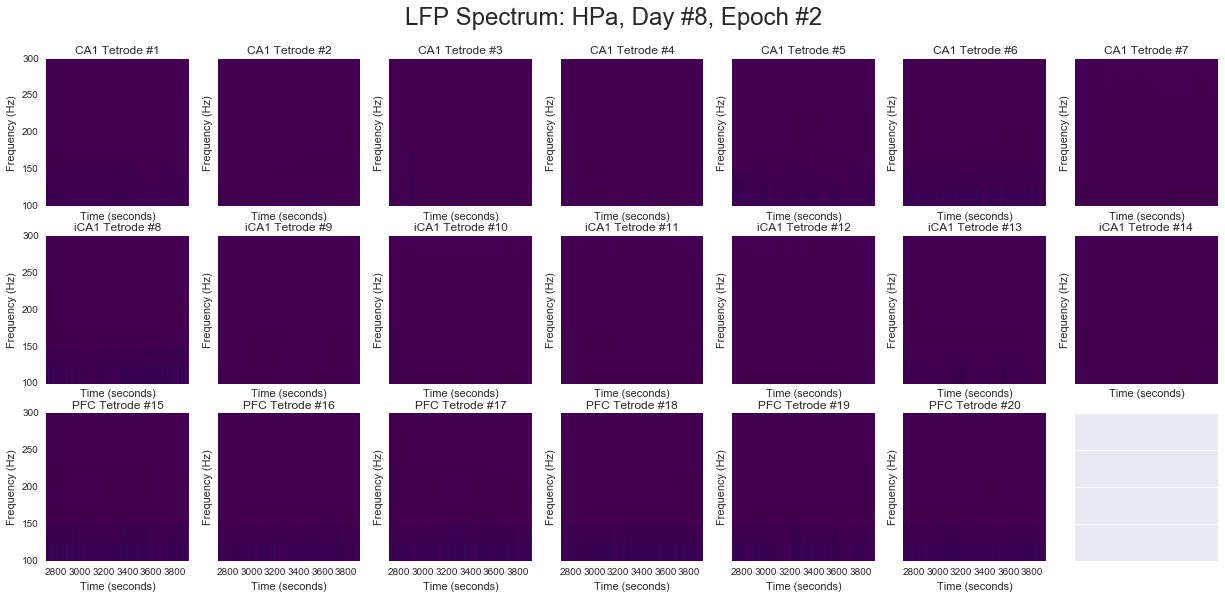

In [33]:
# Spectrum
num_rows = int(np.ceil(len(tetrode_index) / 7))
fig, axis_handles = plt.subplots(num_rows, 7, figsize=(21, 9), sharex=True, sharey=True)
for tetrode_ind, axis_handle in enumerate(tqdm.tqdm_notebook(axis_handles.flatten())):
    try:
        mesh = plot_spectrum(spectrograms_swr[tetrode_ind].loc[(spectrograms_swr[tetrode_ind].frequency >= 100) & (spectrograms_swr[tetrode_ind].frequency <= 300)], axis_handle)
        axis_handle.set_xticks(xticks)
        axis_handle.set_title(tetrode_title(tetrode_index[tetrode_ind], cur_tetrode_info))
    except IndexError:
        axis_handle.xaxis.set_visible(False)
        
plt.suptitle('LFP Spectrograms: HPa, Day #8, Epoch #2', fontsize=24)


# Spectrograms
num_rows = int(np.ceil(len(tetrode_index) / 7))
fig, axis_handles = plt.subplots(num_rows, 7, figsize=(21, 9), sharex=True, sharey=True)
for tetrode_ind, axis_handle in enumerate(tqdm.tqdm_notebook(axis_handles.flatten())):
    try:

        mesh = plot_spectrogram(spectrograms_swr[tetrode_ind].loc[(spectrograms_swr[tetrode_ind].frequency >= 100) & (spectrograms_swr[tetrode_ind].frequency <= 300)], axis_handle)
        axis_handle.set_title(tetrode_title(tetrode_index[tetrode_ind], cur_tetrode_info))
    except IndexError:
        axis_handle.xaxis.set_visible(False)
        
plt.suptitle('LFP Spectrum: HPa, Day #8, Epoch #2', fontsize=24)